In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py
import os

from scipy import signal
from scipy import io

import librosa

In [2]:
import models.models_mae as models_mae

/home/nsagan/autumn23-batlab-project/transformer-interpolation/MaskSpec_forked/mspec_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
def read_all_seqs(dir='../data', files=None):
    if files is None:
        files = map(lambda filename: dir + '/' + filename, os.listdir(dir))

    seqs = []
    for filename in files:
        with h5py.File(filename, 'r') as f:
            seqs.extend([f[h5py.h5r.get_name(elem, f.id)][:] for elem in f['chirp_sequence_array']])

    return seqs

In [41]:
def get_sample(use_wav_example=False, seq_idx=200, mic_idx=0, hopsize=320, upsample_rate=4, scale=1):
    if use_wav_example:
        _, Y = io.wavfile.read('./audioset/Y__p-iA312kg.wav')
        return Y
    seqs = read_all_seqs()
    X = seqs[seq_idx].T[:, 0:4] * scale

    x = signal.resample(X[:, mic_idx], X.shape[0] * upsample_rate)
    x = x * signal.windows.tukey(len(x))
    zeros_to_add = 320319 // 320 * hopsize - len(x)
    if zeros_to_add > 0:
        x = np.hstack((x, np.zeros(zeros_to_add)))

    return x

In [135]:
def mel_spectrogram(x, model, normalize=True):
    old_shape = x.size()
    x = x.reshape(-1, old_shape[2])
    x = model.mel(x)
    if normalize:
        x = (x - model.frame_mean[None, :, None]) / model.frame_std[None, :, None]
    x = x.reshape(old_shape[0], old_shape[1], x.shape[1], x.shape[2])
    return x

In [6]:
def test_model_forward(x, model, device, mask_ratio=0.75):
    model = model.to(device)

    x = torch.from_numpy(x.reshape(1, 1, -1).astype('float32'))
    x = x.to(device)
    x = x.type(torch.FloatTensor).to(device)

    mel_x = mel_spectrogram(x, model)
    mel_x = mel_x[:, :, :model.patch_embed.img_size[0], :model.patch_embed.img_size[1]]

    loss, pred, mask = model.forward(x, mask_ratio)
    x_prime = model.unpatchify(pred[:, :, :, np.newaxis])
    
    return mel_x, x_prime, loss, mask


In [7]:
def plot_specgram(Sx, nfft=256, hoplength=30, FS=250_000):
    plt.figure(figsize=(15, 4))
    plt.imshow(np.flip(Sx, axis=0), aspect='auto')
    plt.colorbar()
    locs, labels = plt.yticks()
    labels = np.array(list(map(lambda x: float(x.get_text().replace('−', '-')), labels)))
    freqs = np.round(FS/1000 / nfft * (Sx.shape[0] - labels))
    
    plt.yticks(locs[1:-1], freqs[1:-1])

    # locs, labels = plt.xticks()
    # labels = np.array(list(map(lambda x: float(x.get_text().replace('−', '-')), labels)))
    # times = np.round(labels / FS * 1000 * hoplength)
    
    # plt.xticks(locs[1:-1], times[1:-1])

    plt.ylabel("kHz")
    # plt.xlabel("Milliseconds")
    plt.xlabel("Spectrogram sample")
    plt.show()

In [8]:
def mask_to_patched_mask(mask, model):
    patchified_mask = model.patchify(torch.from_numpy(1 - mask[np.newaxis, np.newaxis, :, :]))[0, :, :, 0]
    return ~(torch.sum(patchified_mask, axis=1) > 0)

In [197]:
def test_imputation_mel_x(mel_x, model, device, mask):
    model = model.to(device)
    mel_x = torch.from_numpy(mel_x.astype('float32')).to(device).unsqueeze(0).unsqueeze(0)

    patch_mask = mask_to_patched_mask(mask, model).reshape(1, -1).type(torch.FloatTensor).to(device)
    mask = torch.from_numpy(mask.astype('float32')).to(device)

    mel_x_masked = mel_x * mask - 50*(1-mask) # this is just to test that the masking is correct
    latent = model.patch_embed(mel_x_masked)
    latent = latent + model.pos_embed[:, 1:, :]

    D = latent.shape[2]

    ids_keep = torch.nonzero(patch_mask, as_tuple=True)[1]
    ids_mask = torch.nonzero(1 - patch_mask, as_tuple=True)[1]
    ids_restore = torch.argsort(torch.cat((ids_keep, ids_mask))).reshape(1, -1)
    
    latent = torch.gather(latent, dim=1, index=ids_keep.reshape(1, -1).unsqueeze(-1).repeat(1, 1, D))

    cls_token = model.cls_token + model.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(latent.shape[0], -1, -1)
    latent = torch.cat((cls_tokens, latent), dim=1)

    # apply Transformer blocks
    for blk in model.blocks:
        latent = blk(latent)
    latent = model.norm(latent)

    pred = model.forward_decoder(latent, ids_restore)
    x_prime = model.unpatchify(pred[:, :, :, np.newaxis])

    loss = model.forward_loss(mel_x, pred, patch_mask)

    # test = np.zeros((1, ids_restore.shape[1], 16*16, 1))
    # test[:, ids_mask.detach().cpu().numpy(), :, :] = 1
    # test = model.unpatchify(torch.from_numpy(test).to(device))

    return mel_x, x_prime, loss#, test.detach().cpu().numpy()
    

In [198]:
def test_imputation(x, model, device, mask, normalize=True):
    model = model.to(device)

    # patch_mask = mask_to_patched_mask(mask, model).reshape(1, -1).type(torch.FloatTensor).to(device)
    # mask = torch.from_numpy(mask.astype('float32')).to(device)

    x = torch.from_numpy(x.reshape(1, 1, -1).astype('float32'))
    x = x.to(device)
    x = x.type(torch.FloatTensor).to(device)

    mel_x = mel_spectrogram(x, model, normalize=normalize)
    mel_x = mel_x[:, :, :model.patch_embed.img_size[0], :model.patch_embed.img_size[1]]
    return test_imputation_mel_x(mel_x[0][0].detach().cpu().numpy(), model, device, mask)
    

In [10]:
## Setup pytorch

GPU_NUM = '1'

device = torch.device(('cuda:' + GPU_NUM) if (torch.cuda.is_available() and GPU_NUM != '-1') else 'cpu')
print("Using device: {}".format(device))
if device == 'cuda':
    print("Device index: {}".format(torch.cuda.current_device()))


Using device: cuda:1


In [11]:
# STATE = './batlab_audio/output_dir/checkpoint-75.pth'
STATE = './batlab_audio/output_dir/checkpoint-45.pth'
model = models_mae.__dict__['mae_vit_base_patch16'](
    norm_pix_loss=False,
    norm_file='./batlab_audio/mean_std_128.npy',
    hopsize=15,
    device=device
)
checkpoint = torch.load(STATE, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [43]:
idx = np.random.randint(295)
idx

27

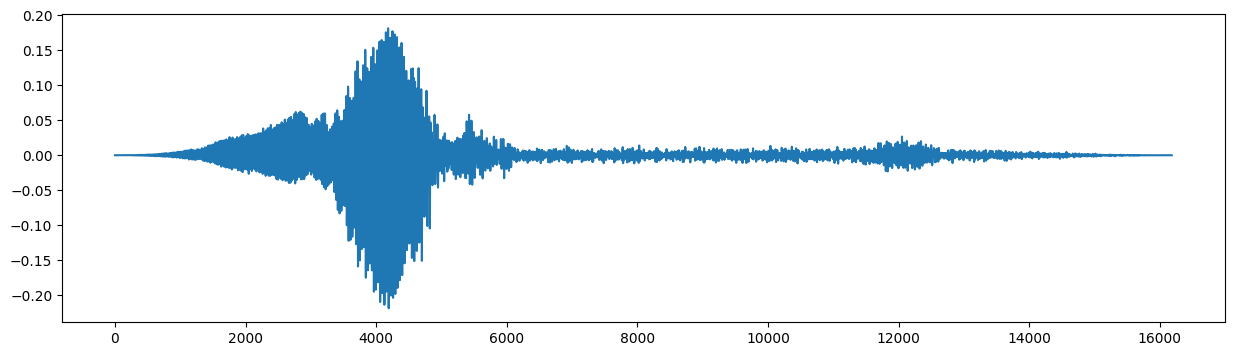

In [122]:
x = get_sample(seq_idx=idx, upsample_rate=4, hopsize=15, mic_idx=0, scale=1)
plt.figure(figsize=(15, 4))
plt.plot(x)

In [143]:
mel_x, x_prime, loss, mask = test_model_forward(x, model, device, 0.8)

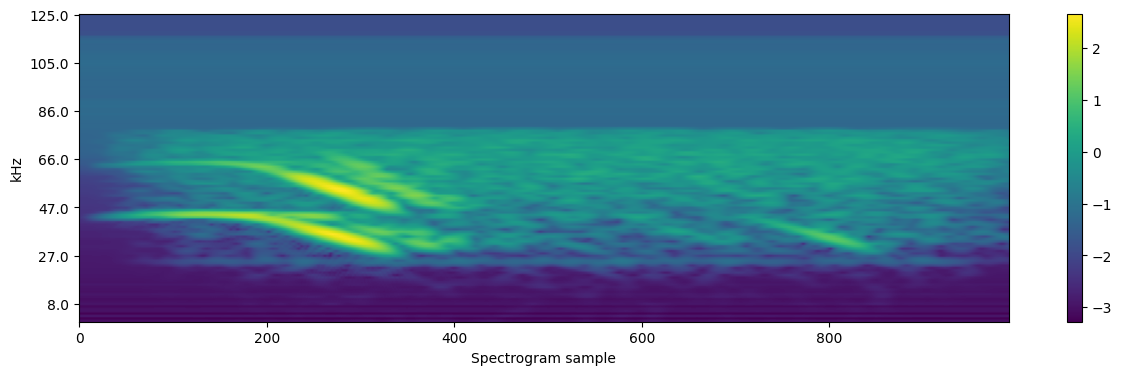

In [144]:
mel_x = mel_x[0][0].detach().cpu().numpy()
plot_specgram(mel_x)

In [53]:
def interval_including(x, a):
    return (x // a) * a, (x + a if x % a == 0 else ((x + a - 1) // a) * a)

In [74]:
interval_including(300, 16)

(288, 304)

In [159]:
mask = np.ones(mel_x.shape)
mask[:, 240:] = 0
# mask[40:80, 200:250] = 0
# mask[50:80, 550:600] = 0

In [76]:
def specgram_sample_to_x_idx(a, hopsize=15):
    return a * hopsize

In [67]:
def get_distorted_x(x, model, multiplicative_distortion=None, additive_distortion=None):
    if multiplicative_distortion is not None:
        x = x * multiplicative_distortion
    if additive_distortion is not None:
        x = x + additive_distortion

    mel_x = mel_spectrogram(torch.from_numpy(x.reshape(1, 1, -1).astype('float32')).to(device), model).detach().cpu().numpy()
    mel_x = mel_x[:, :, :model.patch_embed.img_size[0], :model.patch_embed.img_size[1]]
    return x, mel_x[0][0]
    

In [68]:
mult_dist = np.ones(len(x))
# mult_dist[specgram_sample_to_x_idx(580):specgram_sample_to_x_idx(600)] = 0.1
x_distorted, mel_x_distorted = get_distorted_x(x, model, multiplicative_distortion=mult_dist)

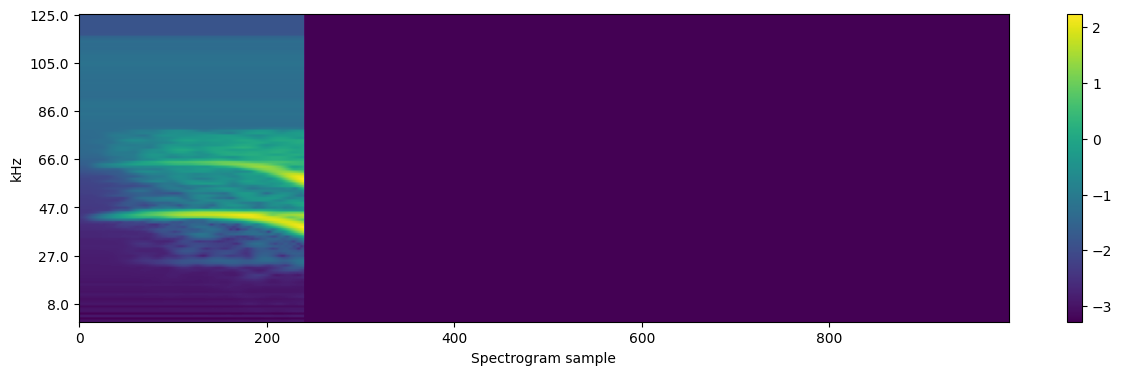

In [170]:
masked_mel = mel_x * mask + np.min(mel_x)*(1-mask) 
plot_specgram(masked_mel)

In [161]:
# semimasked_x = librosa.feature.inverse.mel_to_audio(semimasked_mel_x, sr=32_000, n_fft=1024, hop_length=10)
# plt.figure(figsize=(15, 3))
# plt.plot(semimasked_x)

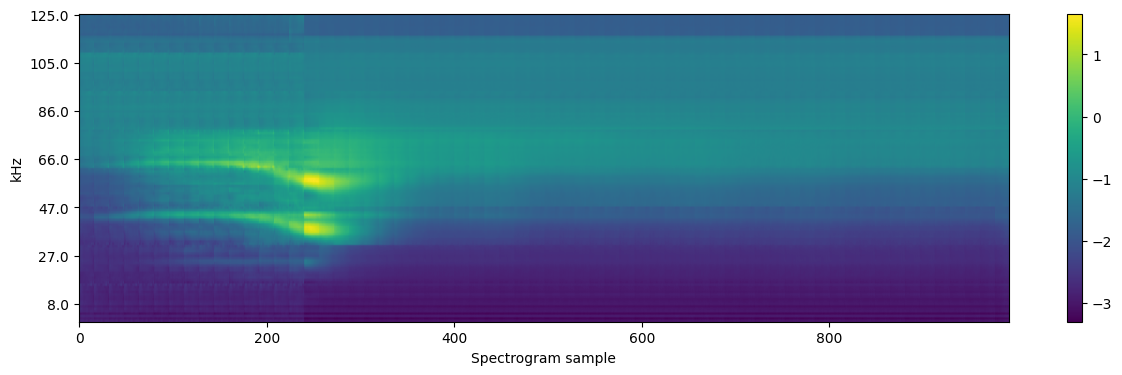

In [196]:
_, x_prime, loss = test_imputation_mel_x(mel_x, model, device, mask)
x_prime = x_prime[0][0].detach().cpu().numpy()
plot_specgram(x_prime)

In [188]:
scale_factor = np.max(mel_x) / np.max(x_prime)

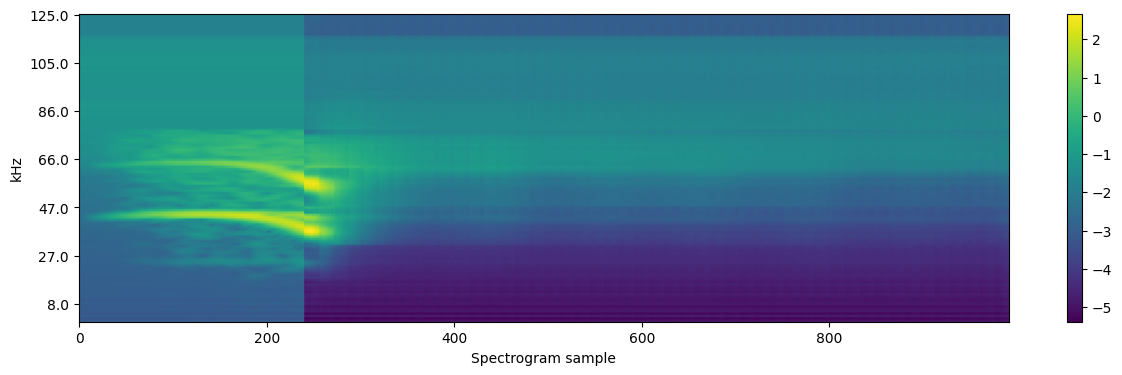

In [189]:
reconst_mel_x = mel_x * mask + scale_factor*x_prime * (1-mask)
plot_specgram(reconst_mel_x)

In [225]:
def iterative_extrapolation(mel_x, mask_start, model, device, max_mask_start=992):
    mask_start = interval_including(mask_start, 16)[0]
    while mask_start < min(mel_x.shape[1], max_mask_start):
        # x = librosa.feature.inverse.mel_to_audio(mel_x, sr=fs, n_fft=n_fft, hop_length=hop_length, win_length=win_length, length=audio_length)
        mask = np.ones(mel_x.shape)
        mask[:, mask_start:] = 0
        _, mel_x_prime, _ = test_imputation_mel_x(mel_x, model, device, mask)
        mel_x_prime = mel_x_prime.detach().cpu().numpy()[0][0]

        # mel_x_prime -= (np.max(mel_x_prime) + np.min(mel_x_prime))/2
        scale_factor = np.max(mel_x) / np.max(mel_x_prime)
        mel_x = mel_x * mask + scale_factor*mel_x_prime * (1-mask)
        
        mask_start += 16
    return mel_x

In [226]:
# x2 = librosa.feature.inverse.mel_to_audio(mel_x, sr=32000, n_fft=1024, hop_length=15, win_length=800, length=mel_x.shape[1] * 15 - 1)
# mel_x2, x_prime, loss, _ = test_model_forward(x, model, device, 0.8)
# mel_x2 = mel_x2[0][0].detach().cpu().numpy()

In [238]:
mel_x_ext = iterative_extrapolation(mel_x, 300, model, device)

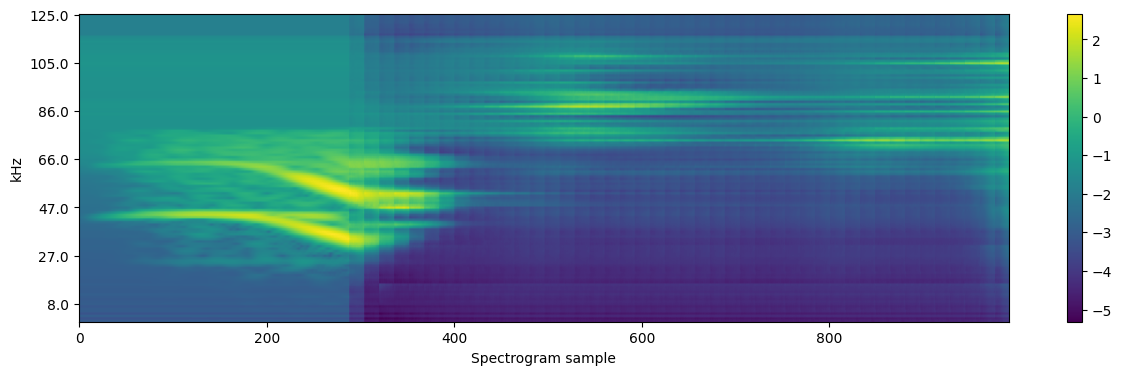

In [239]:
plot_specgram(mel_x_ext)